<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-with-python-cookbook/03_text_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Let's see, how we provide the model with additional data it doesn’t already know.

We perform a similarity search to find relevant information, combine it into a single prompt, and send it to the LLM.

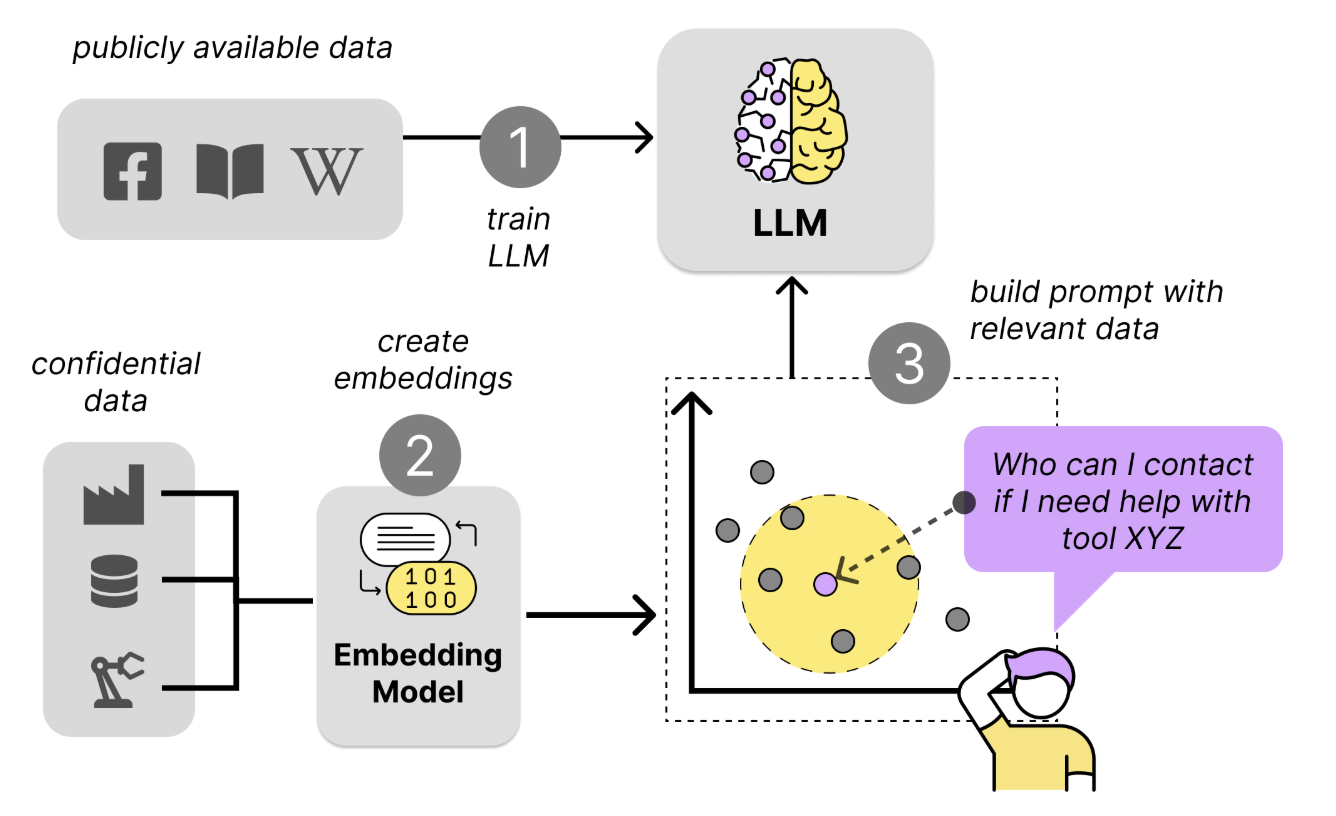

In [ ]:
!pip install sentence-transformers==4.1.0
!pip install requests==2.32.3
!pip install matplotlib==3.10.3
!pip install openai==1.79.0
!pip install langchain-google-genai
!pip install pandas==2.2.3
!pip install rank-bm25
!pip install langchain_text_*splitters
!pip install PyPDF2==3.0.1

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from google.colab import userdata

from numpy.linalg import norm
import pandas as pd
import numpy as np
import os

In [2]:
# --- Configuration ---
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [3]:
# Initialize the ChatGoogleGenerativeAI model
# Use a model that supports audio input, like "gemini-1.5-flash" or "gemini-1.5-pro"
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0, api_key=userdata.get("GOOGLE_API_KEY") )

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

##1.1 How to generate embeddings using the Gemini and HuggingFace API

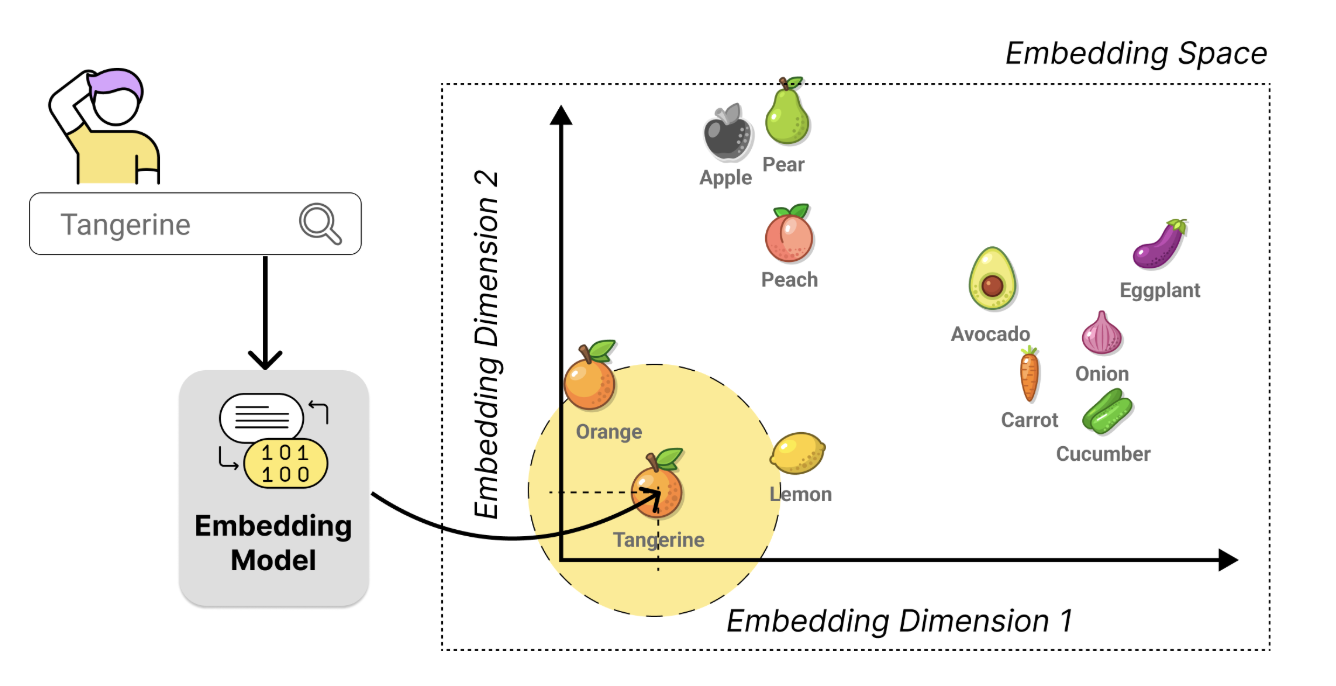

In [ ]:
text_chunks = ["The sky is blue.", "The grass is green."]
embeddings_langchain_list = []

for text_chunk in text_chunks:
    embeddings_langchain = gemini_embeddings.embed_query(text_chunk)
    embeddings_langchain_list.append(embeddings_langchain)

In [ ]:
print("Length of embeddings:", len(embeddings_langchain_list[0]))

Length of embeddings: 768


In [ ]:
embeddings_langchain_list[0][:5]

[-0.015079199336469173,
 0.014919384382665157,
 -0.015354635193943977,
 -0.03445927053689957,
 -0.01124453917145729]

In [ ]:

def create_text_embeddings_using_huggingface():
    '''
    Returns:
        embeddings (list): list of embeddings
    '''
    # tag::create_text_embeddings_using_huggingface[]
    from sentence_transformers import SentenceTransformer

    # Load the model
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    text_chunks = ["The sky is blue.", "The grass is green."]

    # Generate embeddings
    embeddings = model.encode(text_chunks)

    # end::create_text_embeddings_using_huggingface[]

    return embeddings

embeddings_huggingface = create_text_embeddings_using_huggingface()

In [ ]:
embeddings_huggingface[:,:5] # from every row, only select 5 column value

array([[ 0.01791951,  0.01352881,  0.04279673,  0.01671825,  0.02982377],
       [-0.0136322 ,  0.0391215 ,  0.00031122, -0.05203088,  0.03019598]],
      dtype=float32)

In [ ]:
print(embeddings_huggingface[:, :5])
print("Length of embeddings:", len(embeddings_huggingface[0]))

[[ 0.01791951  0.01352881  0.04279673  0.01671825  0.02982377]
 [-0.0136322   0.0391215   0.00031122 -0.05203088  0.03019598]]
Length of embeddings: 384


##1.2 Visualizing the Embedding

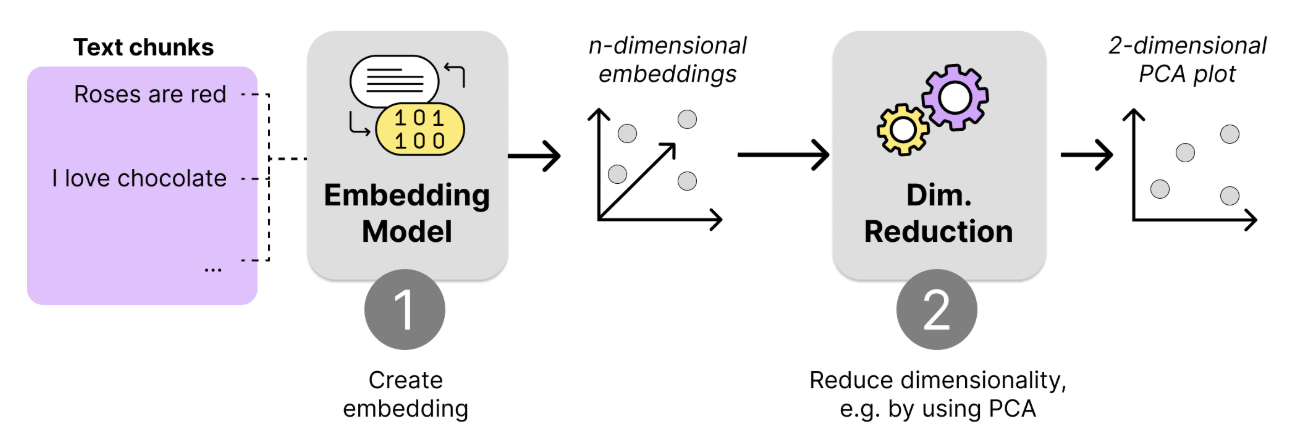

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Define text chunks
text_chunks = [
    "The sky is blue.",
    "The sun is shining.",
    "I love chocolate.",
    "Ice cream is delicious.",
    "Roses are red.",
    "Violets are blue.",
]

# Generate embeddings for text chunks
embeddings = []
for text_chunk in text_chunks:
    embeddings_langchain = gemini_embeddings.embed_query(text_chunk)
    embeddings.append(embeddings_langchain)

# Convert embeddings to a DataFrame
embeddings_df = pd.DataFrame(
    embeddings, columns=[f"dim_{i}" for i in range(len(embeddings[0]))]
)

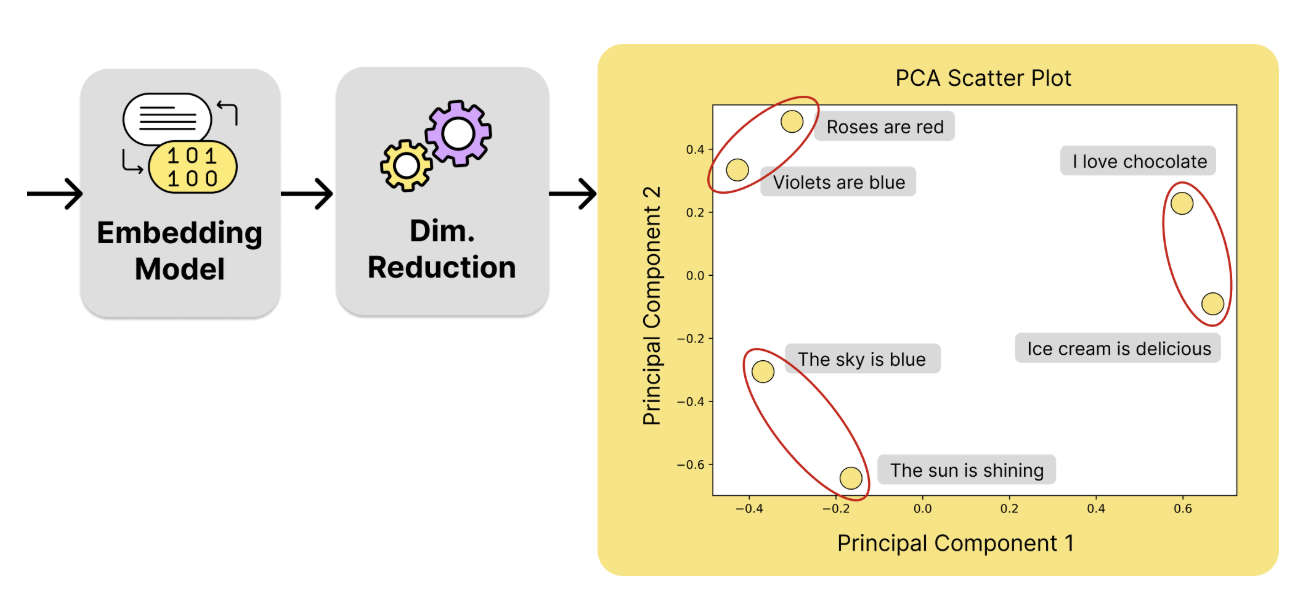

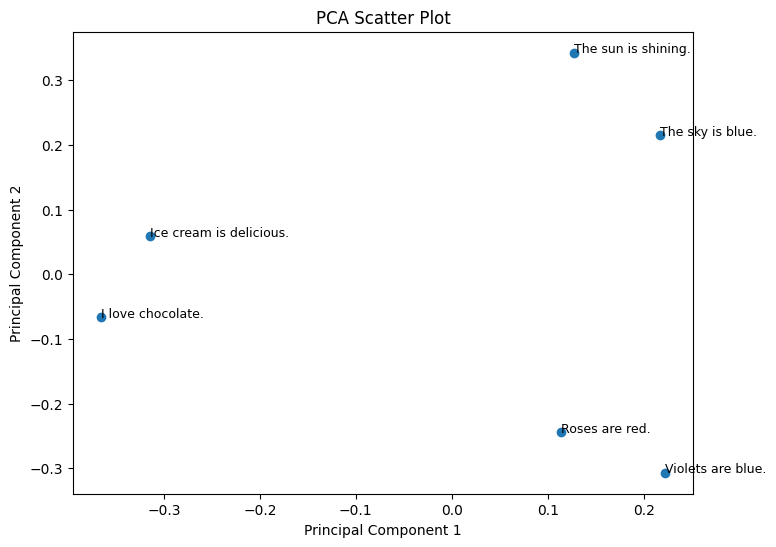

In [ ]:
# Perform PCA with 2 components
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(embeddings_df)

# Create a new DataFrame with reduced dimensions
df_reduced = pd.DataFrame(df_reduced, columns=["PC1", "PC2"])
df_reduced["text"] = text_chunks  # Add original text chunks for labeling

# Function to create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_reduced["PC1"], df_reduced["PC2"])

# Add labels to each point
for i, label in enumerate(df_reduced["text"]):
    plt.text(df_reduced["PC1"][i], df_reduced["PC2"][i], label, fontsize=9)

# Add labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")

# Save the plot
plt.savefig("principal_component_plot.svg", format="svg")
plt.show()

##1.3 Calculating the Distance Between Embeddings

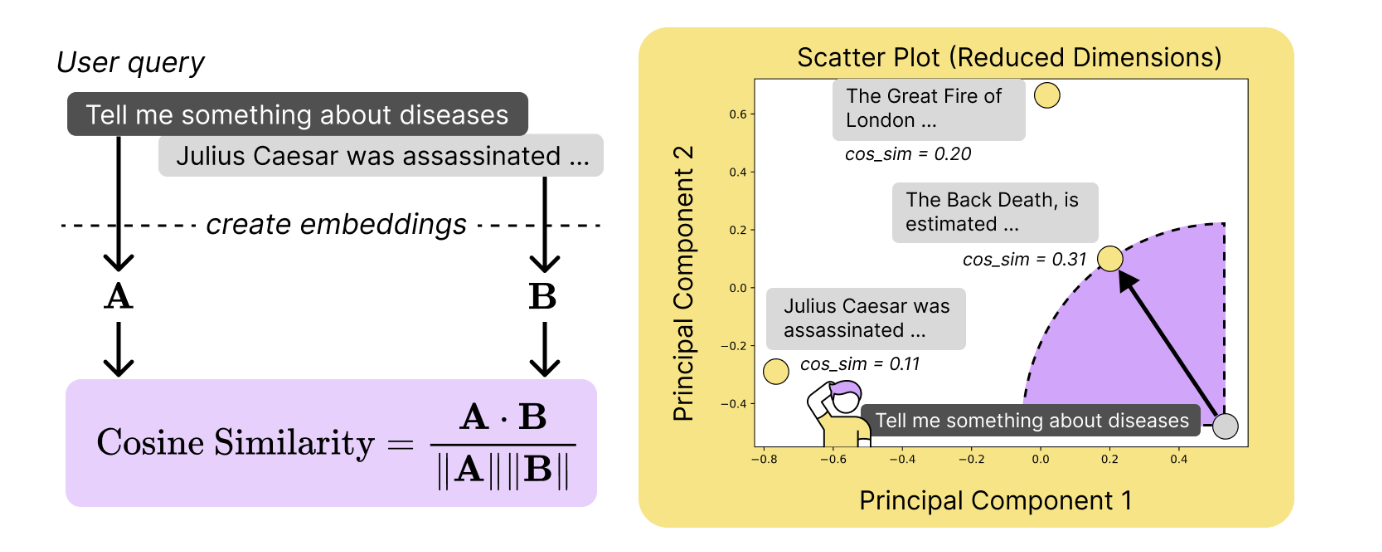

In [ ]:
text_chunks = [
    "The Great Fire of London in 1666 destroyed over 13,000 houses.",
    "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
    "The Black Death, is estimated to have killed nearly one-third of the population",
]
users_question = "Tell me something interesting about diseases in history"

embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

# Generate embeddings for text chunks
embeddings = []
for text_chunk in text_chunks:
    embeddings_langchain = gemini_embeddings.embed_query(text_chunk)
    embeddings.append(embeddings_langchain)

# Convert embeddings to a DataFrame
embeddings_df["embedding"] = embeddings

In [ ]:
users_question_embedding = gemini_embeddings.embed_query(users_question)

In [ ]:
# create a list to store the calculated cosine similarity
cos_sim = []

def calculate_cosine_similarity(text_chunk_embedding, users_question_embedding):
    A = text_chunk_embedding
    B = users_question_embedding

    # calculate the cosine similarity
    cosine = np.dot(A, B) / (norm(A) * norm(B))
    return cosine

# Apply function calculate_cosine_distance to the correct column
embeddings_df["similarity"] = embeddings_df["embedding"].apply(
    calculate_cosine_similarity, users_question_embedding=users_question_embedding
)

In [ ]:
embeddings_df

,text_chunk,embedding,similarity
0,The Great Fire of London in 1666 destroyed ove...,"[-0.01341010257601738, 0.016411693766713142, -...",0.636494
1,Julius Caesar was assassinated on the Ides of ...,"[0.010892914608120918, 0.026007739827036858, 0...",0.560946
2,"The Black Death, is estimated to have killed n...","[-0.00016916943422984332, 0.024595536291599274...",0.699264


In [ ]:
def calculate_cosine_distance_using_sentence_transformer(document_embeddings, query_embedding):
    """
    Calculate the cosine distance between document embeddings and a query embedding
    using the sentence-transformers library.

    Args:
        document_embeddings (list): List of document embeddings.
        query_embedding (list): Query embedding.

    Returns:
        scores (numpy.ndarray): Cosine similarity scores.
    """
    # tag::calculate_cosine_distance_using_sentence_transformer[]
    from sentence_transformers.util import cos_sim

    for document_embedding in document_embeddings:
        # Compute cosine_similarity between documents and query
        scores = cos_sim(document_embedding, query_embedding)
    # end::calculate_cosine_distance_using_sentence_transformer[]
    return scores

scores = calculate_cosine_distance_using_sentence_transformer(
    document_embeddings=embeddings_df["embedding"].tolist(),
    query_embedding=embeddings_df["embedding"].tolist()
)

In [ ]:
scores

tensor([[0.7367, 0.6441, 1.0000]])

##1.4 Generating Embeddings for Images and Text using CLIP

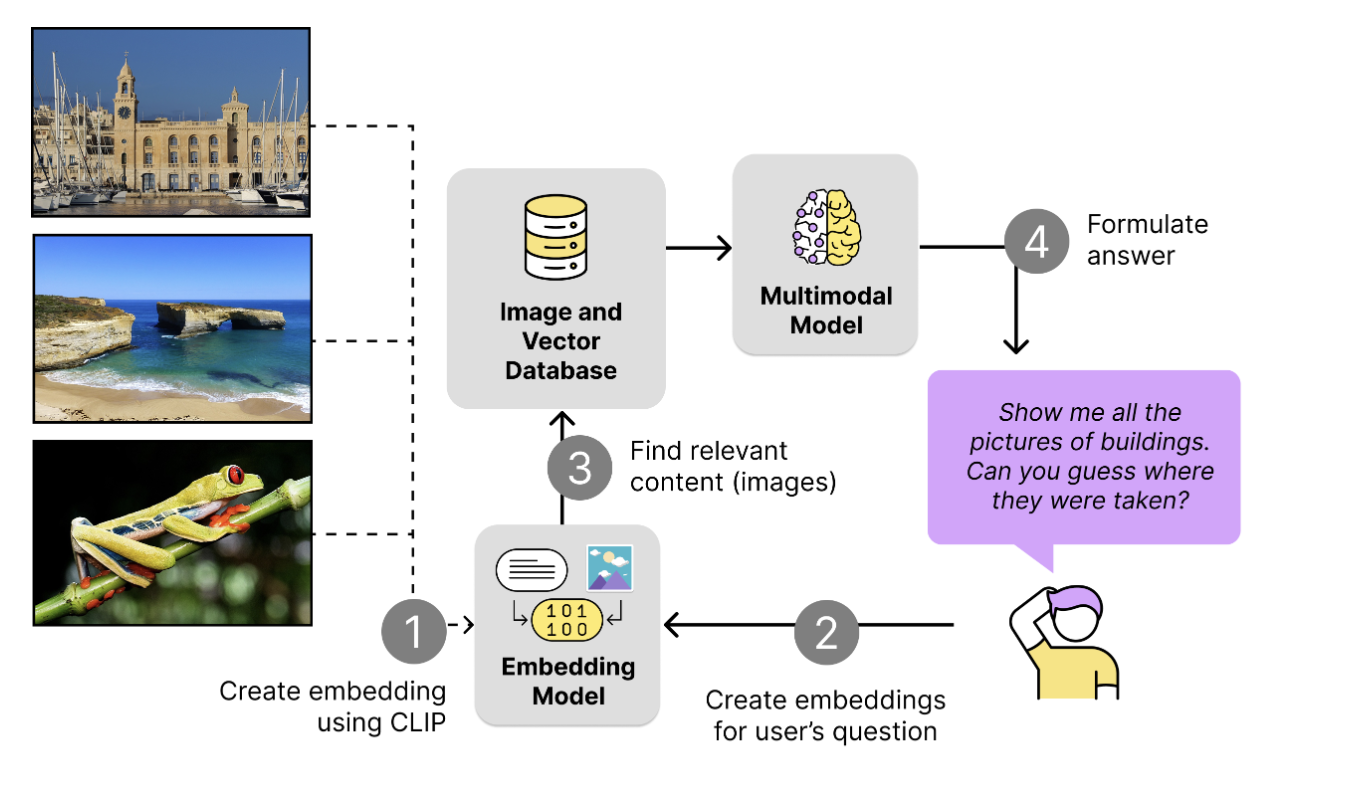

In [ ]:
!wget https://github.com/polzerdo55862/RAG-with-Python-Cookbook/raw/main/datasets/images/cat.jpg
!wget https://github.com/polzerdo55862/RAG-with-Python-Cookbook/raw/main/datasets/images/dog.jpg

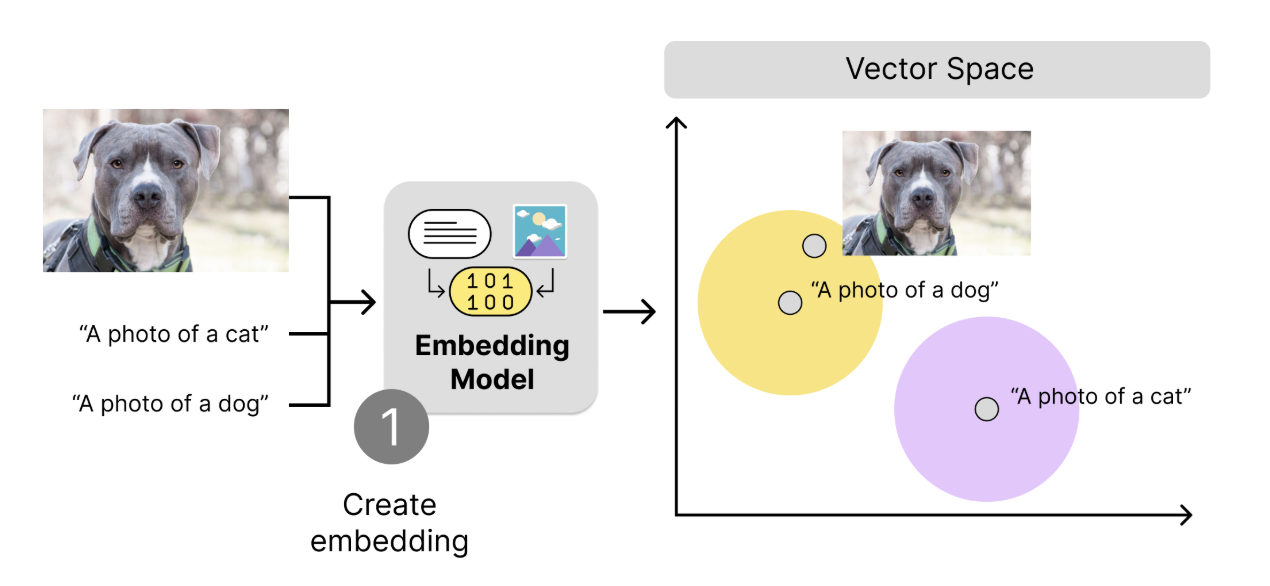

In [5]:
def create_embeddings_using_clip():
    # tag::create_embeddings_using_clip[]
    import torch
    from PIL import Image
    from transformers import CLIPProcessor, CLIPModel

    # Load the model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Text and image inputs
    descriptions = ["A photo of a cat", "A photo of a dog"]
    images = [
        Image.open("cat.jpg"),
        Image.open("dog.jpg"),
    ]

    # Inference
    with torch.no_grad():
        inputs = processor(
            text=descriptions,
            images=images,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        outputs = model(**inputs)

    # get the similarity scores between each image embedding and each text embedding
    dot_products_per_text = outputs.logits_per_text

    # Calculate probabilities
    probabilities = dot_products_per_text.softmax(dim=1)
    # end::create_embeddings_using_clip[]

    return probabilities, dot_products_per_text

In [ ]:
probabilities, dot_products_per_text = create_embeddings_using_clip()

In [7]:
print(probabilities)

print("Probability that the first image is a cat:", probabilities[0][0].item())
print("Probability that the second image is a dog:", probabilities[1][1].item())

tensor([[9.9995e-01, 5.3788e-05],
        [1.2071e-01, 8.7929e-01]])
Probability that the first image is a cat: 0.9999462366104126
Probability that the second image is a dog: 0.8792924284934998


### How to use embeddings to train text classification models

In [ ]:
import sys
import pandas as pd
import os

def hybrid_search():
    """
    This function is used in chapter 3: Embeddings for the
    recipe hybrid search. It is combining keyword search using the
    BM25 algorithm and semantic search using embedding models and
    cosine similarity.
    """
    # bm25 keyword search algorithm
    # tag::hybrid_search_bm25[]
    from rank_bm25 import BM25Okapi

    text_chunks = [
        "The Great Fire of London in 1666 destroyed over 13,000 houses.",
        "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
        """The Black Death, is estimated to have killed nearly one-third of the European
        population""",
    ]
    tokenized_chunks = [chunk.split(" ") for chunk in text_chunks]

    bm25 = BM25Okapi(tokenized_chunks)

    users_query = "Tell me something interesting about diseases in history"
    tokenized_query = users_query.split(" ")

    doc_scores = bm25.get_scores(tokenized_query)

    ranking_keyword_search = (
        pd.DataFrame(doc_scores, columns=["scores"])
        .sort_values(by="scores", ascending=False)
        .index.to_list()
    )
    # end::hybrid_search_bm25[]

    # tag::hybrid_search_semantic_search[]
    from sentence_transformers.util import cos_sim

    embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    embeddings = []

    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    embeddings_df["embedding"] = embeddings_df["text_chunk"].apply(
        create_embeddings, client=client
    )

    users_question_embedding = create_embeddings(text_chunk=users_query, client=client)

    # Compute cosine_similarity between documents and query
    embeddings_df["similarity"] = cos_sim(
        embeddings_df["embedding"], users_question_embedding
    )

    ranking_semantic_search = embeddings_df.sort_values(
        by=["similarity"], ascending=False
    ).index
    # end::hybrid_search_semantic_search[]

    return ranking_semantic_search, ranking_keyword_search


In [ ]:
ranking_semantic_search, ranking_keyword_search = hybrid_search()

In [ ]:
ranking_semantic_search, ranking_keyword_search

(Index([2, 0, 1], dtype='int64'), [0, 1, 2])

In [ ]:
def calculate_hybrid_search_score(ranking_semantic_search, ranking_keyword_search):
    # tag::hybrid_search_combined_rating[]
    #  calculate a combined similarity score using Reciprocal Rank Fusion (RRF)
    combined_score = []

    for i in range(0, len(ranking_semantic_search), 1):
        k = 60
        rrf_score = 1 / (k + ranking_keyword_search[i]) + 1 / (
            k + ranking_semantic_search[i]
        )
        combined_score.append(rrf_score)

    combined_score_df = pd.DataFrame(combined_score, columns=["combined_score"])
    new_ranking = (
        combined_score_df.sort_values(by=["combined_score"], ascending=False).index + 1
    )

    # end::hybrid_search_combined_rating[]

    return new_ranking


In [ ]:
new_ranking = calculate_hybrid_search_score(
    ranking_semantic_search, ranking_keyword_search
)

In [ ]:
new_ranking

NameError: name 'new_ranking' is not defined

### How to optimize similarity search by combining similarity search and keyword search

In [ ]:
def hybrid_search():
    """
    This function is used in chapter 3: Embeddings for the
    recipe hybrid search. It is combining keyword search using the
    BM25 algorithm and semantic search using embedding models and
    cosine similarity.
    """
    # bm25 keyword search algorithm
    # tag::hybrid_search_bm25[]
    from rank_bm25 import BM25Okapi
    import pandas as pd
    import os

    text_chunks = [
        "The Great Fire of London in 1666 destroyed over 13,000 houses.",
        "Julius Caesar was assassinated on the Ides of March (March 15) in 44 BCE.",
        """The Black Death, is estimated to have killed nearly one-third of the European
        population""",
    ]
    tokenized_chunks = [chunk.split(" ") for chunk in text_chunks]

    bm25 = BM25Okapi(tokenized_chunks)

    users_query = "Tell me something interesting about diseases in history"
    tokenized_query = users_query.split(" ")

    doc_scores = bm25.get_scores(tokenized_query)

    ranking_keyword_search = (
        pd.DataFrame(doc_scores, columns=["scores"])
        .sort_values(by="scores", ascending=False)
        .index.to_list()
    )
    # end::hybrid_search_bm25[]

    # tag::hybrid_search_semantic_search[]
    from sentence_transformers.util import cos_sim

    embeddings_df = pd.DataFrame(text_chunks, columns=["text_chunk"])

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    embeddings = []

    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    embeddings_df["embedding"] = embeddings_df["text_chunk"].apply(
        create_embeddings, client=client
    )

    users_question_embedding = create_embeddings(text_chunk=users_query, client=client)

    # Compute cosine_similarity between documents and query
    embeddings_df["similarity"] = cos_sim(
        embeddings_df["embedding"], users_question_embedding
    )

    ranking_semantic_search = embeddings_df.sort_values(
        by=["similarity"], ascending=False
    ).index
    # end::hybrid_search_semantic_search[]

    return ranking_semantic_search, ranking_keyword_search


In [ ]:
ranking_semantic_search, ranking_keyword_search = hybrid_search()

In [ ]:
ranking_semantic_search, ranking_keyword_search

In [ ]:

def calculate_hybrid_search_score(ranking_semantic_search, ranking_keyword_search):
    # tag::hybrid_search_combined_rating[]
    #  calculate a combined similarity score using Reciprocal Rank Fusion (RRF)
    combined_score = []

    for i in range(0, len(ranking_semantic_search), 1):
        k = 60
        rrf_score = 1 / (k + ranking_keyword_search[i]) + 1 / (
            k + ranking_semantic_search[i]
        )
        combined_score.append(rrf_score)

    combined_score_df = pd.DataFrame(combined_score, columns=["combined_score"])
    new_ranking = (
        combined_score_df.sort_values(by=["combined_score"], ascending=False).index + 1
    )

    # end::hybrid_search_combined_rating[]

    return new_ranking


In [ ]:
calculate_hybrid_search_score(
    ranking_semantic_search, ranking_keyword_search
)

In [ ]:
calculate_hybrid_search_score

### Performing Text Classification Using Embeddings

In [ ]:
chunks_df

,text,label,embedding
0,The\n \nHistory\n \nof\n \nDeep\n \nLearning\n...,Deep_Learning,"[0.01142459362745285, -0.06355778127908707, 0...."
1,learn\n \nfrom\n \nvast\n \namounts\n \nof\n \...,Deep_Learning,"[0.04786442220211029, -0.023677771911025047, 0..."
2,practical\n \napplications.\n \nThis\n \nartic...,Deep_Learning,"[-0.006355909164994955, -0.03264368325471878, ..."
3,industries.\n \nEarly\n \nFoundations\n \n(194...,Deep_Learning,"[-0.017487941309809685, -0.051235076040029526,..."
4,McCulloch\n \nand\n \nWalter\n \nPitts\n \npro...,Deep_Learning,"[0.011484782211482525, -0.04983634874224663, -..."
...,...,...,...
84,initiatives.\n \nClubs\n \nare\n \nalso\n \nfo...,Premier_League,"[0.010999810881912708, 0.029332827776670456, 0..."
85,From\n \nits\n \nhumble\n \nbeginnings\n \nin\...,Premier_League,"[0.024797702208161354, -0.024624811485409737, ..."
86,"its\n \nmix\n \nof\n \nhistory,\n \ncompetitio...",Premier_League,"[0.03827759623527527, -0.04071657359600067, 0...."
87,game.\n \nAs\n \nit\n \nadapts\n \nto\n \nmode...,Premier_League,"[0.03319929912686348, -0.004885807633399963, 0..."


In [ ]:

def building_a_classification_model_using_embeddings(chunks_df):
    from openai import OpenAI
    import os
    import pandas as pd
    def create_embeddings(text_chunk, client):
        embedding = (
            client.embeddings.create(input=[text_chunk], model="text-embedding-3-small")
            .data[0]
            .embedding
        )
        return embedding

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    # tag::building_a_classification_model_using_embeddings[]
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification

    y = chunks_df["label"]
    X = chunks_df["embedding"].apply(
        lambda x: pd.Series(eval(x)) if isinstance(x, str) else pd.Series(x)
    )

    # Train a random forest classifier
    clf = RandomForestClassifier()
    clf.fit(X, y)

    # end::building_a_classification_model_using_embeddings[]

    # tag::classification_model_predict_probability[]
    # Predict probabilities
    test_embedding = create_embeddings(
        text_chunk="What is the name of the top football league in England?",
        client=client,
    )

    X_test = [test_embedding]

    # Predict the most likely class
    predicted_classes = clf.predict(X_test)  # e.g. ['Premier_League']
    probabilities = clf.predict_proba(X_test)  # e.g. array([[0.06, 0.94]])
    # end::classification_model_predict_probability[]

    return predicted_classes, probabilities


In [ ]:
predicted_classes, probabilities = building_a_classification_model_using_embeddings(chunks_df)

In [ ]:
predicted_classes, probabilities

(array(['Premier_League'], dtype=object), array([[0.13, 0.87]]))